In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import math
import copy
import numpy as np

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=50):
    super(PositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, d_model) # torch.Size([50, 128])
    position = torch.arange(0, max_len).float().unsqueeze(1) # torch.Size([50, 1]) # 0~50
    div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                         (-torch.log(torch.Tensor([10000])) / d_model)) # [max_len / 2]
                        #生成一個數位 [0， 2， 4， ...， d_model-2] 的張量（偶數索引）。
    pe[:, 0::2] = torch.sin(position * div_term) #將 sine 函數應用於位置編碼張量 （pe） 的偶數維數。
    pe[:, 1::2] = torch.cos(position * div_term) #將餘弦函數應用於位置編碼張量 （pe） 的奇數維數。
    pe = pe.unsqueeze(0) # torch.Size([1, 50, 128])
    # register pe to buffer and require no grads#緩衝區的參數在訓練期間不會更新
    self.register_buffer('pe', pe)
  def forward(self, x):
    # x: [batch, seq_len, d_model]
    # we can add positional encoding to x directly, and ignore other dimension
    return x + self.pe[:,:x.size(1)]# x.size(1)= 50

torch.Size([2, 50, 128])


In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon
    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta

class Embeddings(nn.Module): # word embedding + positional encoding
    """Construct the embeddings from protein/target, position embeddings."""
    def __init__(self, hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type,substructure_size):
        super(Embeddings, self).__init__()
        self.word_embeddings = nn.Embedding(substructure_size, hidden_size)#(2586,128)# 50個onehot categorical id(0~2585)用128維來表示類別資訊
        #Learned Positional Embedding
        #self.position_embeddings = nn.Embedding(max_drug_len, hidden_size)#(50, 128)# 50個pos id(0~50)用128維vector來表示位置資訊
        #Sinusoidal Position Encoding
        self.position_embeddings = PositionalEncoding(hidden_size, max_len=max_drug_len)#(128,50)
        self.LayerNorm = LayerNorm(hidden_size)#128
        self.dropout = nn.Dropout(hidden_dropout_prob)#0.1
    def forward(self, input_ids):# torch.Size([bsz, 50]) # 50個子結構id 
        seq_length = input_ids.size(1) #input_ids:(batchsize=64,50)# seq_length:50 # 50個onehot categorical id(0~2585)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device) #position_ids:torch.Size([50]) (0~50)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)#position_ids:torch.Size([64, 50])
        words_embeddings = self.word_embeddings(input_ids) #input_ids:(batchsize=64,50)# generate(50,128)類別特徵
        
        #Learned Positional Embedding
        # position_embeddings = self.position_embeddings(position_ids)# generate(50,128)位置特徵
        # embeddings = words_embeddings + position_embeddings # embeddings:torch.Size([bsz, 50, 128])
        
        #Sinusoidal Position Encoding
        pos_encoder = PositionalEncoding(d_model=128, max_len=50)
        embeddings = pos_encoder(words_embeddings)  # Shape: [bsz, 50, 128]
        # words_embeddings: torch.Size([bsz, 50, 128])50個sub,其對應的representation 
        # position_embeddings: torch.Size([bsz, 50, 128])
        
        embeddings = self.LayerNorm(embeddings)#LayerNorm embeddings torch.Size([bsz, 50, 128])
        embeddings = self.dropout(embeddings)#dropout embeddings torch.Size([bsz, 50, 128])
        return embeddings # emb.shape:torch.Size([bsz, 50, 128])
    

In [ ]:
class Type_Encoding(nn.Module):
    def __init__(self, drug_cell_dim ,max_drug_len=50, num_types = 2, trans=False):
        self.embedding_dim = drug_cell_dim
        self.type_embedding = nn.Embedding(num_types, self.embedding_dim) #(2,128)
        
    def forward(self, omic_embeddings, drug_emb_masked):
        type_ids = torch.arange(2, dtype=torch.long, device=drug_emb_masked.device)
        type_ids = type_ids.unsqueeze(0).expand_as(omic_embeddings.size(0), omic_embeddings.size(1))
        type_embeddings = self.type_embedding(type_ids)

        
        append_embeddings = torch.cat([drug_emb_masked, omic_embeddings], dim=1) #shape:[bsz,52,128] #Concatenate along the second dimension


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob):
        super(SelfAttention, self).__init__()# (128,8,0.1)
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))
        self.num_attention_heads = num_attention_heads #8 頭數
        self.attention_head_size = int(hidden_size / num_attention_heads)#128/8=16 頭的維度
        self.all_head_size = self.num_attention_heads * self.attention_head_size#8*16=128 頭的維度總和等於feature數

        self.query = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.key = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.value = nn.Linear(hidden_size, self.all_head_size)#(128,128)

        self.dropout = nn.Dropout(attention_probs_dropout_prob)#0.1

    def transpose_for_scores(self, x): # x: torch.Size([bsz, 50, 128]) # diveide the whole 128 features into 8 heads, result 16 features per head
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) # (8,16)
        # x.size()[:-1] torch.Size([bsz, 50]) # new_x_shape: torch.Size([bsz, 50, 8, 16])
        x = x.view(*new_x_shape) # changes the shape of x to the new_x_shape # x torch.Size([bsz, 50, 8, 16])
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask): 
        # hidden_states:emb.shape:torch.Size([bsz, 50, 128]); attention_mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
        mixed_query_layer = self.query(hidden_states) #hidden_states: torch.Size([bsz, 50, 128])
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states) # mixed_value_layer: torch.Size([bsz, 50, 128])

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer) #value_layer:torch.Size([bsz, 8, 50, 16])
        
        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))# key_layer.transpose(-1, -2):torch.Size([bsz, 8, 16, 50])
        # attention_scores:torch.Size([bsz, 8, 50, 50])
        # Scaled Dot-Product: Prevent the dot products from growing too large, causing gradient Vanishing.
        attention_scores = attention_scores / math.sqrt(self.attention_head_size) # /16
        # attention_scores:torch.Size([bsz, 8, 50, 50])
        attention_scores = attention_scores + attention_mask #torch.Size([bsz, 1, 1, 50])[-0,-0,-0,-0,....,-10000,-10000,....]
        # attention_scores+ attention_mask:torch.Size([bsz, 8, 50, 50])
        
        # Normalize the attention scores to probabilities.
        attention_probs_0 = nn.Softmax(dim=-1)(attention_scores) # attSention_probs:torch.Size([bsz, 8, 50, 50])
        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs_drop = self.dropout(attention_probs_0)

        context_layer = torch.matmul(attention_probs_drop, value_layer) #context_layer:torch.Size([bsz, 8, 50, 16])
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() #context_layer:torch.Size([bsz, 50, 8, 16])
        # context_layer.size()[:-2] torch.Size([bsz, 50])
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) #new_context_layer_shape:torch.Size([bsz, 50, 128]) #(128,)
        context_layer = context_layer.view(*new_context_layer_shape) #context_layer:torch.Size([bsz, 50, 128])
        return context_layer, attention_probs_0

In [ ]:
class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after self-attention
    def __init__(self, hidden_size, dropout_prob):
        super(SelfOutput, self).__init__()# (128,0.1)
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states    

class Attention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Attention, self).__init__()
        self.selfAttention = SelfAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob)
        self.output = SelfOutput(hidden_size, hidden_dropout_prob)# apply linear and skip conneaction and LayerNorm and dropout after self-attention

    def forward(self, input_tensor, attention_mask):
        # input_tensor:emb.shape:torch.Size([64, 50, 128]); attention_mask: ex_e_mask:torch.Size([64, 1, 1, 50])
        self_output, attention_probs_0 = self.selfAttention(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output, attention_probs_0     

In [ ]:
class Intermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super(Intermediate, self).__init__()# (128,512)
        self.dense = nn.Linear(hidden_size, intermediate_size)

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = F.relu(hidden_states)
        return hidden_states

class Output(nn.Module):# do linear, skip connection, LayerNorm, dropout after intermediate(Feed Forward block)
    def __init__(self, intermediate_size, hidden_size, hidden_dropout_prob):
        super(Output, self).__init__()# (512,128,0.1)
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states # transformer 最後的輸出

In [ ]:
class Encoder(nn.Module):  # Transformer Encoder for drug feature # Drug_SelfAttention
    def __init__(self, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):#(128,512,8,0.1,0.1)
        super(Encoder, self).__init__() # (128,512,8,0.1,0.1)
        self.attention = Attention(hidden_size, num_attention_heads,
                                   attention_probs_dropout_prob, hidden_dropout_prob)# (128,8,0.1,0.1)
        self.intermediate = Intermediate(hidden_size, intermediate_size)# (128,512)
        self.output = Output(intermediate_size, hidden_size, hidden_dropout_prob)# (512,128,0.1)

    def forward(self, hidden_states, attention_mask):
        # hidden_states:emb.shape:torch.Size([64, 50, 128]); attention_mask: ex_e_mask:torch.Size([64, 1, 1, 50])
        attention_output,attention_probs_0 = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output , attention_probs_0    # transformer 最後的輸出


In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_types, num_heads, num_layers, dropout):
        super(TransformerModel, self).__init__()
        self.type_encoding = Type_Encoding(input_dim, num_types)
        self.transformer = nn.Transformer(d_model=input_dim, nhead=num_heads, num_encoder_layers=num_layers, dropout=dropout)
        self.input_dim = input_dim

    def forward(self, substructure, omics):
        # Concatenate substructure and omics sequences
        concatenated_seq = torch.cat((substructure, omics), dim=1)  # Shape: (batch_size, seq_len, input_dim)
        
        # Create type indices
        substructure_type_indices = torch.zeros(substructure.size(0), substructure.size(1), dtype=torch.long, device=substructure.device)
        omics_type_indices = torch.ones(omics.size(0), omics.size(1), dtype=torch.long, device=omics.device)
        
        type_indices = torch.cat((substructure_type_indices, omics_type_indices), dim=1)  # Shape: (batch_size, seq_len)
        
        # Apply type encoding
        type_encoded_seq = concatenated_seq + self.type_encoding.type_embedding(type_indices)
        
        # Transpose for transformer input
        type_encoded_seq = type_encoded_seq.transpose(0, 1)  # Shape: (seq_len, batch_size, input_dim)
        
        # Apply transformer
        transformer_output = self.transformer(type_encoded_seq)  # Shape: (seq_len, batch_size, input_dim)
        
        # Transpose back to original shape
        transformer_output = transformer_output.transpose(0, 1)  # Shape: (batch_size, seq_len, input_dim)
        
        return transformer_output

# Example usage
batch_size = 2
substructure_len, omics_len = 5, 7
input_dim = 128
num_types = 2
num_heads = 8
num_layers = 2
dropout = 0.1

substructure = torch.randn(batch_size, substructure_len, input_dim)
omics = torch.randn(batch_size, omics_len, input_dim)

transformer_model = TransformerModel(input_dim=input_dim, num_types=num_types, num_heads=num_heads, num_layers=num_layers, dropout=dropout)
output = transformer_model(substructure, omics)

print("Transformer Output Shape:", output.shape)  # (batch_size, seq_len, input_dim)

In [ ]:
class Omics_DCSA_model(nn.Module):
    def __init__(self, device,omics_numfeatures_dict, **kwargs):
        super(Omics_DCSA_model, self).__init__()
        omics_encode_dim_dict = kwargs['omics_encode_dim_dict']
        drug_encode_dims = kwargs['drug_encode_dims']
        activation_func = kwargs['activation_func']
        activation_func_final = kwargs['activation_func_final']
        dense_layer_dim = kwargs['dense_layer_dim']
        Drug_SelfAttention = kwargs['Drug_SelfAttention']
        pos_emb_type = kwargs['pos_emb_type']
        hidden_size = kwargs['hidden_size']
        intermediate_size = kwargs['intermediate_size']
        num_attention_heads = kwargs['num_attention_heads']
        attention_probs_dropout_prob = kwargs['attention_probs_dropout_prob']
        hidden_dropout_prob = kwargs['hidden_dropout_prob']
        max_drug_len = kwargs['max_drug_len']
        
        TCGA_pretrain_weight_path_dict = kwargs.get('TCGA_pretrain_weight_path_dict', None)


        self.num_attention_heads = num_attention_heads # num_attention_heads要在forward中使用，所以要設為self.num_attention_heads

        def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
            state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
            encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
            model.load_state_dict(encoder_state_dict)  # Load only the encoder part
            model_keys = set(model.state_dict().keys())  # Check if the keys match
            loaded_keys = set(encoder_state_dict.keys())
            if model_keys == loaded_keys:
                print(f"State_dict for {model} loaded successfully.")
            else:
                print(f"State_dict does not match the model's architecture for {model}.")
                print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)
        
        self.MLP4omics_dict = nn.ModuleDict()
        for omic_type in omics_numfeatures_dict.keys():
            self.MLP4omics_dict[omic_type] = nn.Sequential(
                nn.Linear(omics_numfeatures_dict[omic_type], omics_encode_dim_dict[omic_type][0]),
                activation_func,
                nn.Linear(omics_encode_dim_dict[omic_type][0], omics_encode_dim_dict[omic_type][1]),
                activation_func_final,
                nn.Linear(omics_encode_dim_dict[omic_type][1], omics_encode_dim_dict[omic_type][2])
            )
            # Initialize with TCGA pretrain weight
            if TCGA_pretrain_weight_path_dict is not None:
                load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
            else: # Initialize weights with Kaiming uniform initialization, bias with aero
                self._init_weights(self.MLP4omics_dict[omic_type])

            #apply a linear tranformation to omics embedding to match the hidden size of the drug
            self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][2], hidden_size)
            self._init_weights(self.match_drug_dim)
        
#ESPF            
        self.emb_f = Embeddings(hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type,substructure_size = 2586)#(128,50,0.1,2586)
        if Drug_SelfAttention is False: 
            self.dropout = nn.Dropout(attention_probs_dropout_prob)
        # self.output = SelfOutput(hidden_size, hidden_dropout_prob) # (128,0.1) # apply linear and skip conneaction and LayerNorm and dropout after attention
        # if attention is True  
        elif Drug_SelfAttention is True: 
            self.TransformerEncoder = Encoder(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128,512,8,0.1,0.1)

# Drug_Cell_SelfAttention
        self.Drug_Cell_SelfAttention = Encoder(hidden_size+num_attention_heads, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128+8,512,8,0.1,0.1)

# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(dense_layer_dim, dense_layer_dim),
            activation_func,
            nn.Dropout(p=0),
            nn.Linear(dense_layer_dim, dense_layer_dim),
            activation_func,
            nn.Dropout(p=0),
            nn.Linear(dense_layer_dim, 1),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with aero
        self._init_weights(self.model_final_add)

        self.print_flag = True

    def _init_weights(self, model):
        for layer in model:
            if isinstance(layer, nn.Linear):
                init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
                if layer.bias is not None:
                    init.zeros_(layer.bias)
    def forward(self, omics_tensor_dict,drug, device, **kwargs):
        Drug_SelfAttention=kwargs.get('Drug_SelfAttention', None)
        omic_embeddings_ls = []
        # Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor.to(device=device)) #(bsz, 50)
            #apply a linear tranformation to omics embedding to match the hidden size of the drug
            omic_embed = self.match_drug_dim(omic_embed) #(bsz, 128)
            omic_embeddings_ls.append(omic_embed)
        # omic_embeddings = torch.cat(omic_embeddings_ls, dim=1)  # change list to tensor, because omic_embeddings need to be tensor to torch.cat([omic_embeddings, drug_emb_masked], dim=1) 

    #ESPF encoding        
        mask = drug[:, 1, :].to(device=device) # torch.Size([bsz, 50]),dytpe(long)
        drug_embed = drug[:, 0, :].to(device=device) # drug_embed :torch.Size([bsz, 50]),dytpe(long)
        drug_embed = self.emb_f(drug_embed) # (bsz, 50, 128) #word embedding、position encoding、LayerNorm、dropout
        # Embeddings take int inputs, so no need to convert to float like nn.Linear layer
        
# mask for Drug Cell SelfAttention
        omics_items = torch.ones(mask.size(0), len(omic_embeddings_ls), dtype=mask.dtype, device=mask.device)  # Shape: [bsz, len(omic_embeddings_ls)]
        DrugCell_mask = torch.cat([mask, omics_items], dim=1)  # Shape: [bsz, 50 + len(omic_embeddings_ls)]

        if Drug_SelfAttention is False:
            if self.print_flag is True:
                print("\n Drug_SelfAttention is not applied \n")
                self.print_flag  = False
            # to apply mask to emb, treat mask like attention score matrix (weight), then do softmax and dropout, then multiply with emb
            mask_weight =mask.clone().float().unsqueeze(1).repeat(1, 50, 1)# (bsz, 50)->(bsz,50,50)
            mask_weight = (1.0 - mask_weight) * -10000.0
            mask_weight = nn.Softmax(dim=-1)(mask_weight)
            mask_weight = self.dropout(mask_weight)
            drug_emb_masked = torch.matmul(mask_weight, drug_embed) # emb_masked: torch.Size([bsz, 50, 128])
            # 沒做: class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after 
            # 沒做: positional encoding
            
        elif Drug_SelfAttention is True:
            if self.print_flag is True:
                print("\n Drug_SelfAttention is applied \n")
                self.print_flag  = False
            mask = mask.unsqueeze(1).unsqueeze(2) # mask.shape: torch.Size([bsz, 1, 1, 50])
            mask = (1.0 - mask) * -10000.0
            drug_emb_masked, AttenScorMat_DrugSelf  = self.TransformerEncoder(drug_embed, mask)# hidden_states:drug_embed.shape:torch.Size([bsz, 50, 128]); mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
            # drug_emb_masked: torch.Size([bsz, 50, 128]) 
            # attention_probs_0 = nn.Softmax(dim=-1)(attention_scores) # attention_probs_0:torch.Size([bsz, 8, 50, 50])(without dropout)
        elif Drug_SelfAttention is None:
                print("\n Drug_SelfAttention is assign to None , please assign to False or True \n")

# Drug_Cell_SelfAttention
        # omic_embeddings_ls:[(bsz,128),(bsz,128)] 
        # # drug_emb_masked:[bsz,50,128] #已經做完word embedding和position encoding

        omic_embeddings = torch.stack(omic_embeddings_ls, dim=1) #shape:[bsz,c,128] #Stack omic_embeddings_ls along the second dimension
        # Type encoding (to distinguish between drug and omics)
        drug_type_encoding = torch.ones_like(drug_emb_masked[..., :1])  # Shape: [bsz, 50, 1]
        omics_type_encoding = torch.zeros_like(omic_embeddings[..., :1])  # Shape: [bsz, i, 1]
        # Concatenate type encoding with the respective data
        drug_emb_masked = torch.cat([drug_emb_masked, drug_type_encoding], dim=-1)  # Shape: [bsz, 50, 129]
        omic_embeddings = torch.cat([omic_embeddings, omics_type_encoding], dim=-1)  # Shape: [bsz, c, 129]

        # Final concatenated tensor (drug sequence and omics data with type encoding)
        append_embeddings = torch.cat([drug_emb_masked, omic_embeddings], dim=1)  # Shape: [bsz, 50+c, 129]

        padding_dim = self.num_attention_heads - 1  # Extra dimensions to add
        print("padding_dim", padding_dim)
        pad = torch.zeros(append_embeddings.size(0), append_embeddings.size(1), padding_dim, device=append_embeddings.device)
        append_embeddings = torch.cat([append_embeddings, pad], dim=-1)  # New shape: [bsz, 50+i, new_hidden_size]

        append_embeddings, AttenScorMat_DrugCellSelf  = self.Drug_Cell_SelfAttention(append_embeddings, DrugCell_mask)
        # append_embeddings: torch.Size([bsz, 50+c, 136]) # AttenScorMat_DrugCellSelf:torch.Size([bsz, 8, 50+c, 50+c])(without dropout)

        #skip connect the omics embeddings # not as necessary as skip connect the drug embeddings 
        append_embeddings = torch.cat([ torch.cat(omic_embeddings_ls, dim=1), append_embeddings.reshape(append_embeddings.size(0), -1)], dim=1) # dim=1: turn into 1D 
        #omic_embeddings_ls(bsz, 128) , append_embeddings(bsz, 50+c, 136)
        # drug 有50*128，omices有i*128，可能會差太多，看drug要不要先降維根omics一樣i*128 # 先不要
    
    # Final MLP
        output = self.model_final_add(append_embeddings)
        return {"outputs": output, 
                "AttenScorMat_DrugSelf":AttenScorMat_DrugSelf, 
                "AttenScorMat_DrugCellSelf":AttenScorMat_DrugCellSelf}



In [ ]:
kwargs={"a":1,"b":2,"c":3}
def train(**kwargs):
    print(kwargs)
    best_epoch=40
    hts=100
    train_ouput_dict={"best_epoch":best_epoch,"hts":hts
            }
    return train_ouput_dict

train_ouput_dict=train(kwargs)
print(train_ouput_dict)
fdgh=train_ouput_dict.get('fdgh',None)
print(fdgh)

{'a': 1, 'b': 2, 'c': 3}
{'best_epoch': 40, 'hts': 100}
None


In [8]:

def model(a,b,**kwargs):
    ESPF = kwargs.get("ESPF")  # Get from kwargs
    Drug_SelfAttention = kwargs.get("Drug_SelfAttention") 
    print(ESPF)
    print(Drug_SelfAttention)
    return {"a":a,"b":b,"ESPF":ESPF,"Drug_SelfAttention":Drug_SelfAttention}

ESPF=True
Drug_SelfAttention=False
a=1
b=2
train_ouput_dict=model(a,b,**{"ESPF":ESPF,"Drug_SelfAttention":Drug_SelfAttention})
print(train_ouput_dict)

True
False
{'a': 1, 'b': 2, 'ESPF': True, 'Drug_SelfAttention': False}


In [1]:
def train_model(model_name, batch_size=32, **kwargs):
    print(f"Training {model_name} with batch size {batch_size}.")
    
    # Check if any additional arguments were passed
    for key, value in kwargs.items():
        print(f"{key}: {value}")


# Calling the function with different sets of parameters

train_model("Omics_DrugESPF_Model", batch_size=64, learning_rate=0.001, epochs=50)
print("\n")
train_model("Another_Model", optimizer="Adam", dropout=0.2)

Training Omics_DrugESPF_Model with batch size 64.
learning_rate: 0.001
epochs: 50


Training Another_Model with batch size 32.
optimizer: Adam
dropout: 0.2


In [35]:
model_output_dict= { "a":1, "b":2, "c":3}
AttenScorMat_DrugCellSelf = model_output_dict.get('AttenScorMat_DrugCellSelf', None)
print(AttenScorMat_DrugCellSelf)

None


In [28]:
my_dict = {'a': 5, 'b': 6}
def printer1(adict):
    return adict
def printer2(**kwargs):
    return kwargs





def printer3(**kwargs):
    
    return kwargs

printer3(**my_dict)


{'a': 5, 'b': 6}

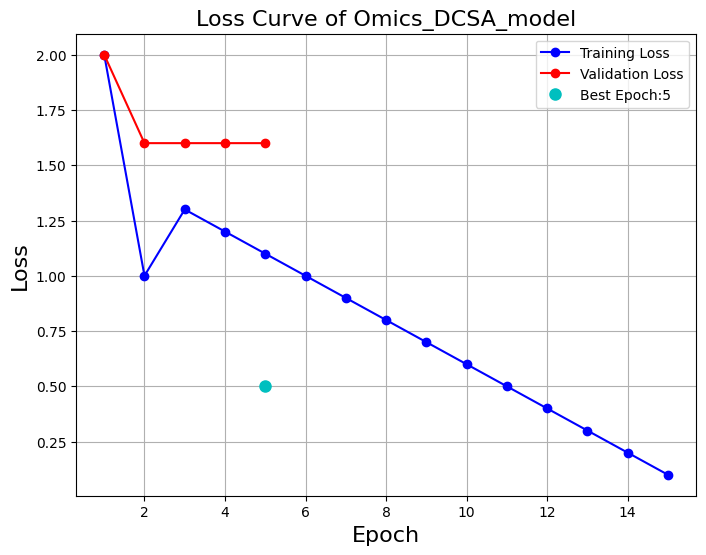

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


train_epoch_loss_list=[2,1,1.3,1.2,1.1,1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
val_epoch_loss_list=[2,1.6,1.6,1.6,1.6]
best_epoch = 5
best_val_loss = 0.5
model_name = 'Omics_DCSA_model'
fig= plt.figure(figsize=(8, 6))
# Plot training loss
plt.plot(range(1, len(train_epoch_loss_list) + 1), train_epoch_loss_list, marker='o', linestyle='-', color='b', label='Training Loss')
# Plot validation loss
plt.plot(range(1, len(val_epoch_loss_list) + 1), val_epoch_loss_list, marker='o', linestyle='-', color='r', label='Validation Loss')
# Mark the best epoch
plt.plot(best_epoch, best_val_loss , marker='o', markersize=8, linestyle='', color='c', label=f'Best Epoch:{best_epoch}')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curve of '+ model_name, fontsize=16)
plt.legend()  # Add legend to differentiate between training and validation losses
plt.grid(True)
# Set y-axis limit
train_max = max(train_epoch_loss_list)
val_max = max(val_epoch_loss_list)
train_min = min(train_epoch_loss_list)
val_min = min(val_epoch_loss_list)
if (train_min <= 1.5 < train_max) and (val_min <= 1.5 < val_max):
    plt.ylim(top=1.5, bottom=0)
else:
    plt.ylim(top=None, bottom=None)